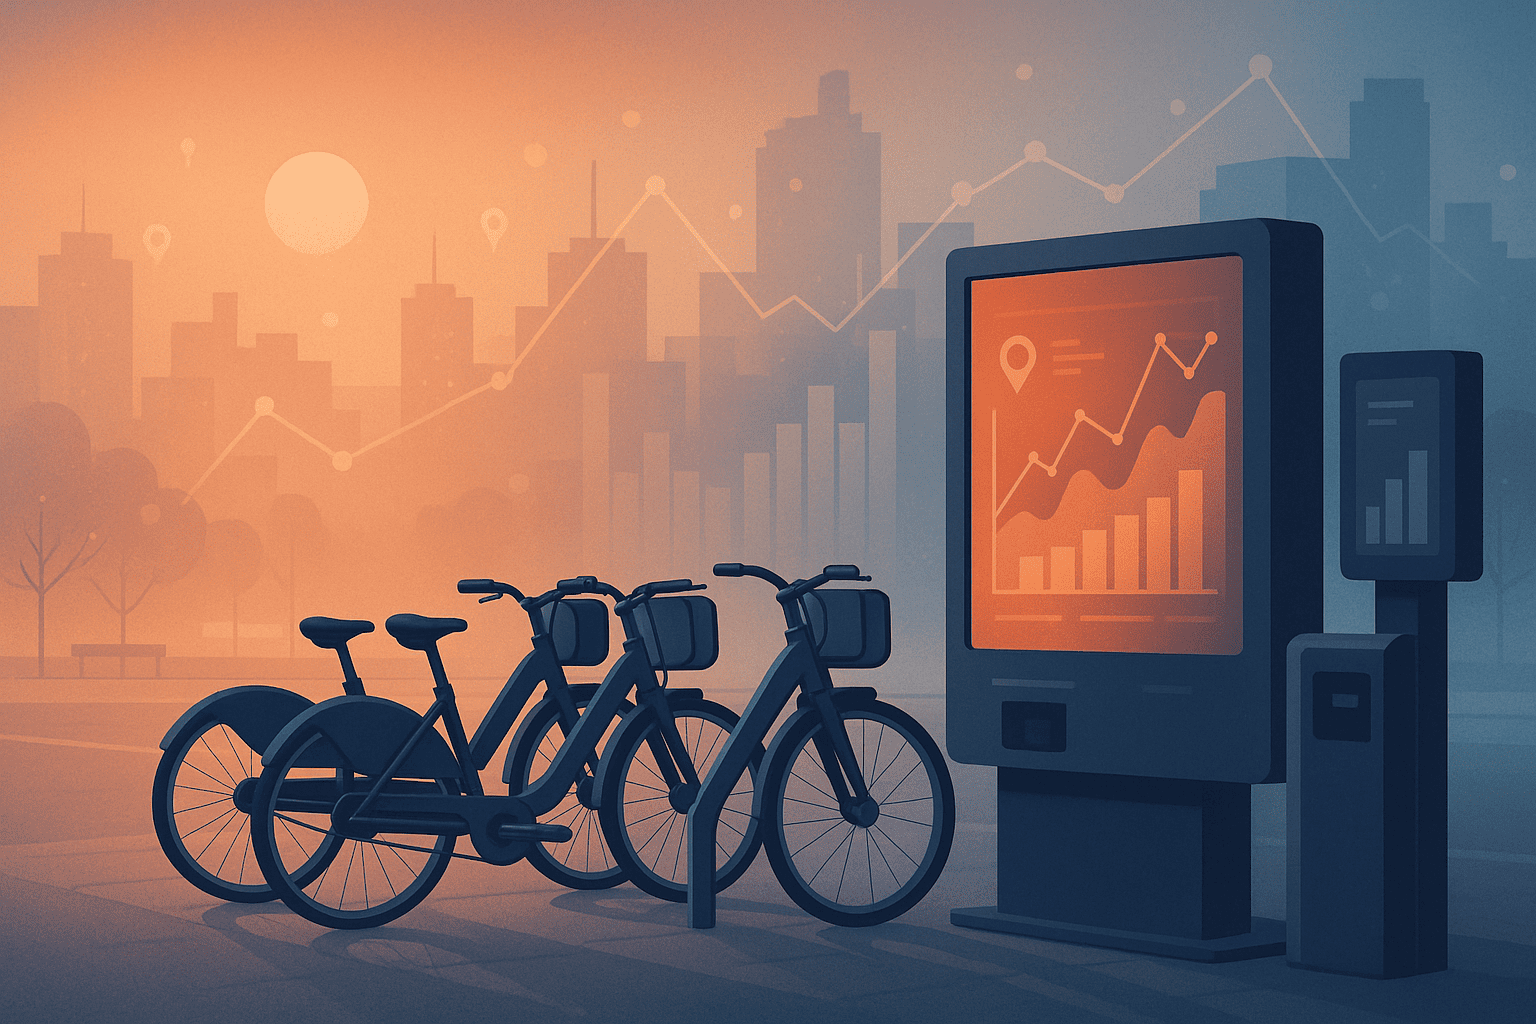

# Bike Rental Demand Time Series Forecast Modelling

This notebook explores various time series forecasting techniques to predict daily bike rental demand. We will start by analysing the historical data, then implement and evaluate several forecasting models, including Naive, ARIMA, and Prophet (with and without external regressors, including artificial ones). The goal is to understand which models are most effective for this dataset and how incorporating relevant factors can improve forecasting accuracy.

In [ ]:
# CHECK GPU
# This command checks if a GPU is available and shows its status.

Sat Jun 28 15:46:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# INSTALL AND IMPORT LIBRARY
# Install the ucimlrepo library to fetch datasets from the UCI Machine Learning Repository.
!pip install ucimlrepo

# Import the fetch_ucirepo function from the library.
from ucimlrepo import fetch_ucirepo

# FETCH DATASET
# Fetch the "Bike Sharing" dataset using its ID (275).
bike_sharing = fetch_ucirepo(id=275)

# SEPARATE FEATURES AND TARGET
# Separate the dataset into features (input variables) and targets (output variable).
# X contains the features like date, season, weather, etc.
X = bike_sharing.data.features
# y contains the target variable, which is the count of total rental bikes ('cnt').
y = bike_sharing.data.targets

# DISPLAY METADATA AND VARIABLE INFORMATION
# Print the metadata of the dataset, which includes information about the dataset's origin,
# abstract, tasks, etc.
print(bike_sharing.metadata)

# Print the variable information, which describes each column in the dataset,
# its role (e.g., feature, target, ID), type, and description.
print(bike_sharing.variables)

{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'ID': 422, 'type': 'NATIVE', 'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'venue': 'Progress

In [ ]:
import pandas as pd

# Combine features and target into a single DataFrame for easier manipulation.
df = pd.concat([X, y], axis=1)

# View the first few rows of the combined DataFrame to understand its structure.
print(df.head())

# Convert the 'dteday' column to datetime objects. This is important for time series analysis.
df['dteday'] = pd.to_datetime(df['dteday'])
# Set the 'dteday' column as the index of the DataFrame.
# This allows for easy time-based operations like resampling.
df.set_index('dteday', inplace=True)

# Drop columns that won't be used for daily analysis.
# Resample the data to get the daily total rentals by summing the 'cnt' for each day.
df_daily = df[['cnt']].resample('D').sum()  # daily total rentals

       dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1   0        0        6           0           1   
1  2011-01-01       1   0     1   1        0        6           0           1   
2  2011-01-01       1   0     1   2        0        6           0           1   
3  2011-01-01       1   0     1   3        0        6           0           1   
4  2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  cnt  
0  0.24  0.2879  0.81        0.0   16  
1  0.22  0.2727  0.80        0.0   40  
2  0.22  0.2727  0.80        0.0   32  
3  0.24  0.2879  0.75        0.0   13  
4  0.24  0.2879  0.75        0.0    1  


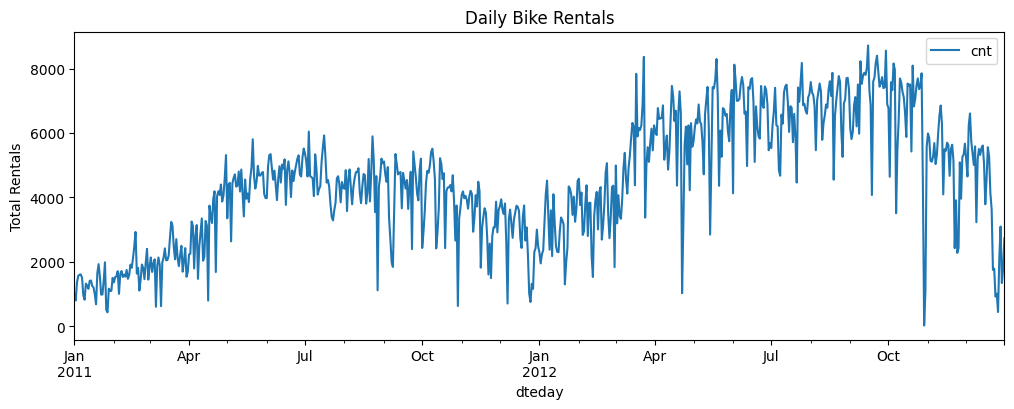

In [ ]:
# Visualise the Time Series

# Import the matplotlib library for plotting.
import matplotlib.pyplot as plt

# Plot the daily bike rentals time series.
# figsize sets the size of the plot.
# title sets the title of the plot.
df_daily.plot(figsize=(12, 4), title='Daily Bike Rentals')
# Set the label for the y-axis.
plt.ylabel('Total Rentals')
# Display the plot.
plt.show()

In [ ]:
# Split the data into training and testing sets.
# We'll use data up to June 30, 2012, for training our model.
train = df_daily[:'2012-06-30']
# And data from July 1, 2012, onwards for testing how well the model performs on new data.
test = df_daily['2012-07-01':]

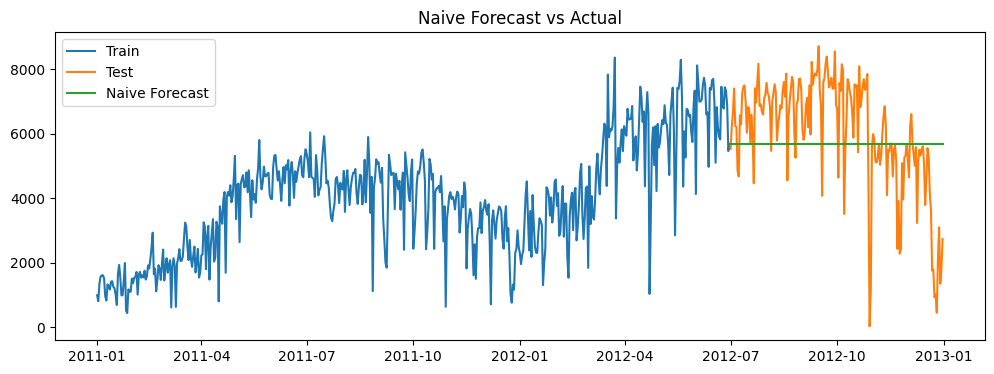

MAE: 1414.24
RMSE: 1777.14


In [ ]:
# Implement a simple Naive Forecast.
# This forecast just predicts the last known value from the training set for all future periods in the test set.
naive_forecast = test.copy()
naive_forecast['naive'] = train['cnt'].iloc[-1]  # Use the last value from the training data as the forecast

# Visualize the results.
# Plot the training data, the actual test data, and the naive forecast to see how they compare.
plt.figure(figsize=(12,4))
plt.plot(train['cnt'], label='Train')
plt.plot(test['cnt'], label='Test')
plt.plot(naive_forecast['naive'], label='Naive Forecast')
plt.legend()
plt.title('Naive Forecast vs Actual')
plt.show()

# Evaluate the Naive Forecast using common metrics.
# Import necessary libraries for evaluation.
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE).
# MAE measures the average magnitude of errors in a set of predictions, without considering their direction.
# It's the average of the absolute differences between the actual values and the predicted values.
mae = mean_absolute_error(test['cnt'], naive_forecast['naive'])

# Calculate Root Mean Squared Error (RMSE).
# RMSE is another common metric that measures the average magnitude of the errors.
# It is the square root of the average of the squared differences between the actual and predicted values.
# RMSE gives a relatively high weight to large errors.
rmse = np.sqrt(mean_squared_error(test['cnt'], naive_forecast['naive']))

# Print the calculated MAE and RMSE values.
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

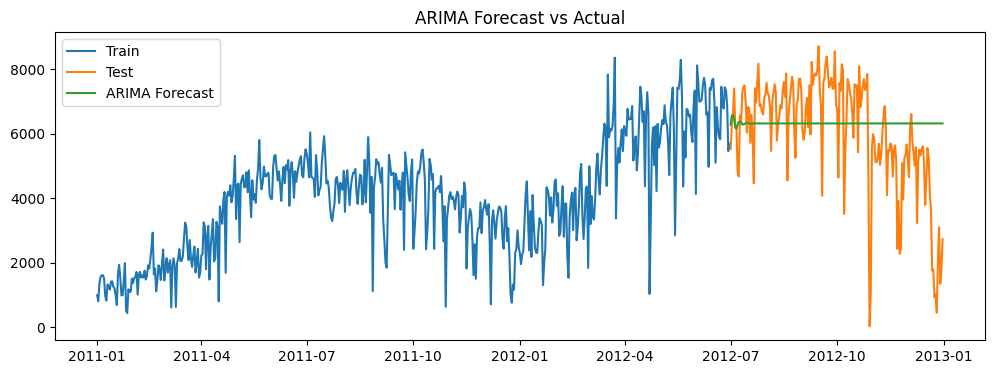

ARIMA MAE: 1315.39
ARIMA RMSE: 1762.45


In [ ]:
# Implement an ARIMA model for forecasting.
# ARIMA (AutoRegressive Integrated Moving Average) is a popular time series forecasting model.
# It models the next step in the sequence as a linear function of the differenced observations
# and lagged forecast errors.

# Import the ARIMA model from the statsmodels library.
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model.
# The order (p, d, q) of the ARIMA model needs to be specified.
# p: The number of lag observations (AutoRegressive order).
# d: The number of times that the raw observations are differenced (Integrated order).
# q: The size of the moving average window (Moving Average order).
# For simplicity, we'll start with a basic order (5, 1, 0).
# In a real-world scenario, you would typically use techniques like
# auto_arima or analyse ACF/PACF plots to determine the optimal order.
model = ARIMA(train['cnt'], order=(5, 1, 0))

# Fit the model to the training data.
arima_model_fit = model.fit()

# Make predictions on the test set.
# The start and end dates for the forecast are determined by the index of the test set.
arima_forecast = arima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Create a DataFrame for the ARIMA forecast with the test set index.
arima_forecast = pd.DataFrame(arima_forecast.values, index=test.index, columns=['arima_forecast'])

# Visualize the results.
# Plot the training data, the actual test data, and the ARIMA forecast.
plt.figure(figsize=(12, 4))
plt.plot(train['cnt'], label='Train')
plt.plot(test['cnt'], label='Test')
plt.plot(arima_forecast['arima_forecast'], label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

# Evaluate the ARIMA Forecast using MAE and RMSE.
# Calculate Mean Absolute Error (MAE) for the ARIMA forecast.
mae_arima = mean_absolute_error(test['cnt'], arima_forecast['arima_forecast'])

# Calculate Root Mean Squared Error (RMSE) for the ARIMA forecast.
rmse_arima = np.sqrt(mean_squared_error(test['cnt'], arima_forecast['arima_forecast']))

# Print the calculated MAE and RMSE values for the ARIMA forecast.
print(f"ARIMA MAE: {mae_arima:.2f}")
print(f"ARIMA RMSE: {rmse_arima:.2f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/kgvt8glm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/5cgj0raw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75966', 'data', 'file=/tmp/tmp3r26o186/kgvt8glm.json', 'init=/tmp/tmp3r26o186/5cgj0raw.json', 'output', 'file=/tmp/tmp3r26o186/prophet_model4w1uzztp/prophet_model-20250628160125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


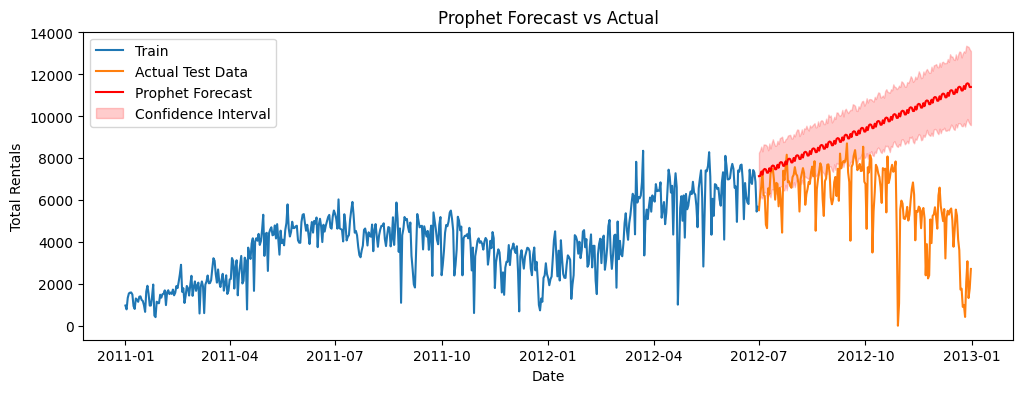

Prophet MAE: 3357.90
Prophet RMSE: 4264.76


In [ ]:
# Implement a Prophet model for forecasting.
# Prophet is a time series forecasting model developed by Facebook.
# It is designed to handle time series data with strong seasonal effects and can incorporate the impact of holidays.

# Install the prophet library.
!pip install prophet

# Import the Prophet model.
from prophet import Prophet

# Prepare the data for Prophet.
# Prophet requires the input DataFrame to have two columns: 'ds' (datetime) and 'y' (the value to forecast).
# Our df_daily DataFrame has the date as the index and the 'cnt' column as the value.
# We need to reset the index to make the date a regular column and rename the columns to 'ds' and 'y'.
df_prophet = df_daily.reset_index().rename(columns={'dteday': 'ds', 'cnt': 'y'})

# Split the data for Prophet.
# We'll use the same split as before: data up to June 30, 2012, for training and from July 1, 2012, onwards for testing.
train_prophet = df_prophet[df_prophet['ds'] <= '2012-06-30']
test_prophet = df_prophet[df_prophet['ds'] > '2012-06-30']

# Define and fit the Prophet model.
# We create a Prophet model instance.
model_prophet = Prophet()
# Fit the model to the training data.
model_prophet.fit(train_prophet)

# Make predictions on the future dates (test set dates).
# We need to create a DataFrame with the future dates we want to forecast.
future = model_prophet.make_future_dataframe(periods=len(test_prophet))
# Generate the forecast for these future dates.
forecast = model_prophet.predict(future)

# Merge the actual test data with the forecast for visualisation and evaluation.
# We'll merge the forecast DataFrame with the actual test_prophet DataFrame on the 'ds' column.
prophet_forecast = test_prophet.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Visualise the results.
# Plot the training data, the actual test data, and the Prophet forecast.
plt.figure(figsize=(12, 4))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='red')
# Plot the confidence interval for the forecast.
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.show()

# Evaluate the Prophet Forecast using MAE and RMSE.
# Calculate Mean Absolute Error (MAE) for the Prophet forecast.
mae_prophet = mean_absolute_error(prophet_forecast['y'], prophet_forecast['yhat'])

# Calculate Root Mean Squared Error (RMSE) for the Prophet forecast.
rmse_prophet = np.sqrt(mean_squared_error(prophet_forecast['y'], prophet_forecast['yhat']))

# Print the calculated MAE and RMSE values for the Prophet forecast.
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/y5zv24cr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/fn0pt949.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82962', 'data', 'file=/tmp/tmp3r26o186/y5zv24cr.json', 'init=/tmp/tmp3r26o186/fn0pt949.json', 'output', 'file=/tmp/tmp3r26o186/prophet_modelq2o66etx/prophet_model-20250628161225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


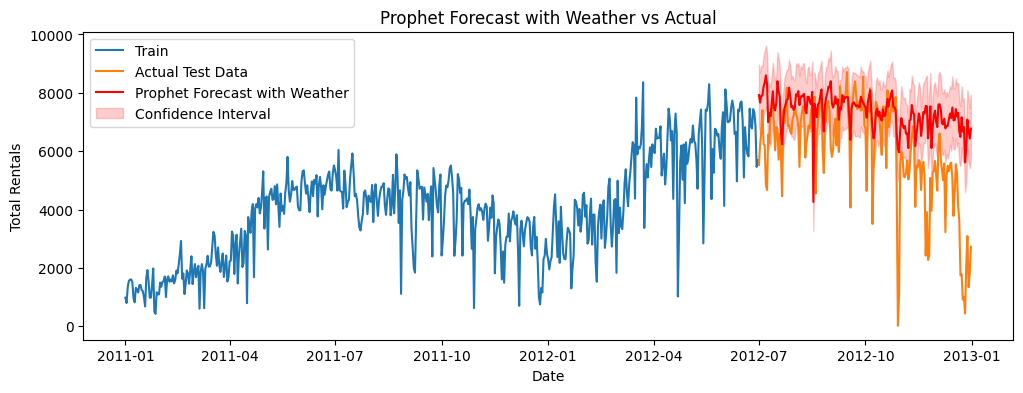

Prophet with Weather MAE: 1433.24
Prophet with Weather RMSE: 1962.86


In [ ]:
# Implement a Prophet model for forecasting with extra regressors (New Model).
# Prophet is a time series forecasting model developed by Facebook.
# It is designed to handle time series data with strong seasonal effects and can incorporate the impact of holidays and extra regressors.

# Install the prophet library if not already installed.
!pip install prophet

# Import the Prophet model.
from prophet import Prophet

# Prepare the data for Prophet.
# Prophet requires the input DataFrame to have two columns: 'ds' (datetime) and 'y' (the value to forecast).
# We also need to include the extra regressors.
# Our original 'df' DataFrame has the date as the index and 'cnt' and weather columns.
# We need to reset the index and rename 'dteday' to 'ds' and 'cnt' to 'y'.
# We also need to ensure the weather columns are included.

# Re-create df_daily including weather columns by taking the mean of hourly weather data for each day
df_daily_weather = df.resample('D').agg({
    'cnt': 'sum',
    'temp': 'mean',
    'atemp': 'mean',
    'hum': 'mean',
    'windspeed': 'mean'
}).reset_index().rename(columns={'dteday': 'ds', 'cnt': 'y'})


# Split the data for Prophet.
# We'll use the same split as before: data up to June 30, 2012, for training and from July 1, 2012, onwards for testing.
train_prophet_weather = df_daily_weather[df_daily_weather['ds'] <= '2012-06-30']
test_prophet_weather = df_daily_weather[df_daily_weather['ds'] > '2012-06-30'] # Use the original split


# Define and fit the Prophet model with extra regressors.
# We create a Prophet model instance.
model_prophet_weather = Prophet()

# Add the extra regressors to the model.
model_prophet_weather.add_regressor('temp')
model_prophet_weather.add_regressor('atemp')
model_prophet_weather.add_regressor('hum')
model_prophet_weather.add_regressor('windspeed')

# Fit the model to the training data including the regressors.
model_prophet_weather.fit(train_prophet_weather)

# Make predictions on the future dates (test set dates) including the regressors.
# We need to create a DataFrame with the future dates and the corresponding regressor values from the test set.
# Prophet requires future regressor values to make forecasts. In a real-world scenario, you would
# need to forecast these weather variables or have access to their future values.
future_weather = model_prophet_weather.make_future_dataframe(periods=len(test_prophet_weather), include_history=False) # Exclude history from future dataframe
# Merge future_weather with the test_prophet_weather to get regressor values for the forecast period
# This assumes we have the actual weather data for the test period available.
future_weather = future_weather.merge(test_prophet_weather[['ds', 'temp', 'atemp', 'hum', 'windspeed']], on='ds', how='left')


# Generate the forecast for these future dates with regressors.
forecast_weather = model_prophet_weather.predict(future_weather)

# Merge the actual test data with the forecast for visualisation and evaluation.
# We'll merge the forecast DataFrame with the actual test_prophet_weather DataFrame on the 'ds' column.
prophet_forecast_weather = test_prophet_weather.merge(forecast_weather[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Visualise the results.
# Plot the training data, the actual test data, and the Prophet forecast with regressors.
plt.figure(figsize=(12, 4))
plt.plot(train_prophet_weather['ds'], train_prophet_weather['y'], label='Train')
plt.plot(test_prophet_weather['ds'], test_prophet_weather['y'], label='Actual Test Data')
plt.plot(prophet_forecast_weather['ds'], prophet_forecast_weather['yhat'], label='Prophet Forecast with Weather', color='red')
# Plot the confidence interval for the forecast.
plt.fill_between(prophet_forecast_weather['ds'], prophet_forecast_weather['yhat_lower'], prophet_forecast_weather['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title('Prophet Forecast with Weather vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.show()

# Evaluate the Prophet Forecast with Weather using MAE and RMSE.
# Calculate Mean Absolute Error (MAE) for the Prophet forecast with regressors.
mae_prophet_weather = mean_absolute_error(prophet_forecast_weather['y'], prophet_forecast_weather['yhat'])

# Calculate Root Mean Squared Error (RMSE) for the Prophet forecast with regressors.
rmse_prophet_weather = np.sqrt(mean_squared_error(prophet_forecast_weather['y'], prophet_forecast_weather['yhat']))

# Print the calculated MAE and RMSE values for the Prophet forecast with regressors.
print(f"Prophet with Weather MAE: {mae_prophet_weather:.2f}")
print(f"Prophet with Weather RMSE: {rmse_prophet_weather:.2f}")

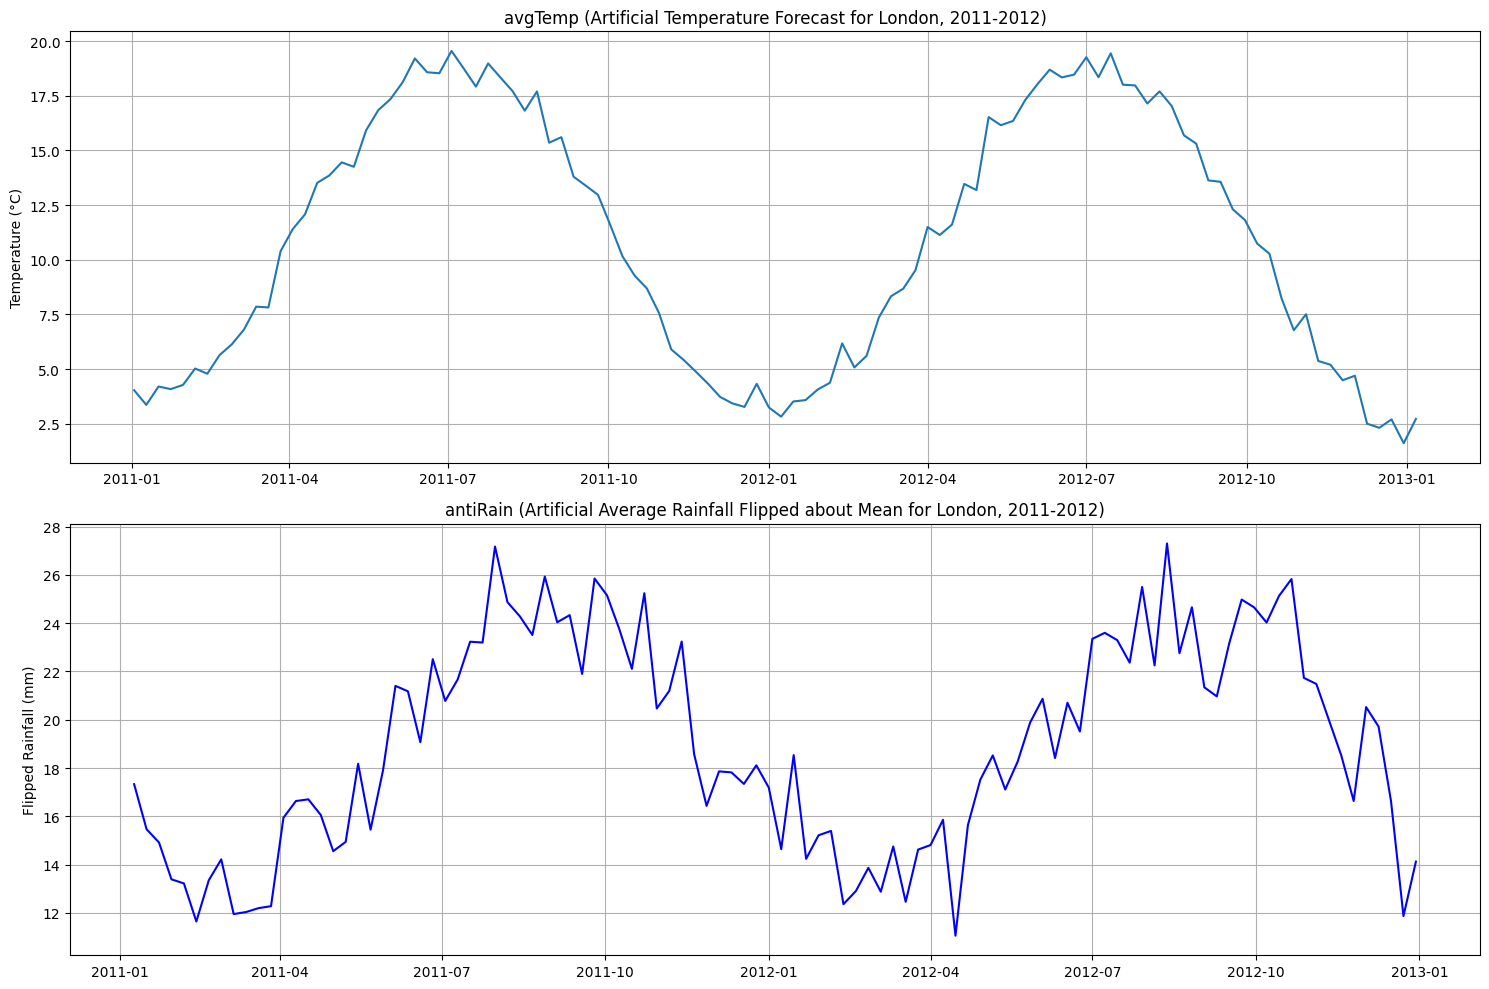

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from holidays import UK # Import UK holidays

# Create a date range from 01-2011 to 12-2012, with daily frequency initially for more detailed holiday data
dates_daily = pd.date_range(start='2011-01-01', end='2012-12-31', freq='D')

# Generate more accurate artificial data for average temperature for London (seasonal pattern)
# London has milder winters and warmer summers than the previous general data
# Average yearly temperature is around 10-11°C, with summer peaks around 18-20°C and winter lows around 5-7°C
avgTempFor_daily = 11 + 8 * np.sin(2 * np.pi * (dates_daily.dayofyear / 365.25 - 0.25)) + np.random.randn(len(dates_daily)) * 1.5

# Generate more accurate artificial data for average rainfall for London
# London's rainfall is relatively evenly distributed throughout the year, but with some variation
# Average yearly rainfall is around 600-700mm, roughly 1-2mm per day on average, with more rainy days in autumn/winter
avgRainfall_daily = 1.8 + 0.8 * np.sin(2 * np.pi * (dates_daily.dayofyear / 365.25 + 0.1)) + np.random.rand(len(dates_daily)) * 2.0
# Rainfall cannot be negative, so set any negative values to 0 using np.where on the numpy array
avgRainfall_daily = np.where(avgRainfall_daily < 0, 0, avgRainfall_daily)


# Get UK holidays for 2011 and 2012
uk_holidays = UK(years=[2011, 2012])
# Create a binary series for holidays based on the date range
holidays_daily = dates_daily.map(lambda date: 1 if date in uk_holidays else 0)


# Create a DataFrame to hold the artificial data
artificial_data_daily = pd.DataFrame({
    'avgTempFor': avgTempFor_daily,
    'avgRainfall': avgRainfall_daily,
    'holidays': holidays_daily
}, index=dates_daily)

# Resample the data to weekly frequency for plotting as requested
artificial_data = artificial_data_daily.resample('W').agg({
    'avgTempFor': 'mean',
    'avgRainfall': 'sum', # Sum rainfall over the week
    'holidays': 'max' # Check if there was any holiday in the week
})

# Calculate the mean of the average rainfall
mean_rainfall = artificial_data['avgRainfall'].mean()
# Create the horizontally flipped rainfall data around its mean
# This is done by taking the mean, subtracting the data, and adding the mean back
flipped_rainfall = mean_rainfall - (artificial_data['avgRainfall'] - mean_rainfall)


# Plot the artificial data
plt.figure(figsize=(15, 10))

# Plot Average Temperature Forecast (now called avgTemp)
plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
plt.plot(artificial_data.index, artificial_data['avgTempFor'])
plt.title('avgTemp (Artificial Temperature Forecast for London, 2011-2012)')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Plot Flipped Rainfall (now called antiRain)
plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
plt.plot(artificial_data.index[1:-1], flipped_rainfall.iloc[1:-1], color='blue') # Exclude first and last data point
plt.title('antiRain (Artificial Average Rainfall Flipped about Mean for London, 2011-2012)')
plt.ylabel('Flipped Rainfall (mm)')
plt.grid(True)


plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/wkujvdpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/lrzv_4oe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72386', 'data', 'file=/tmp/tmp3r26o186/wkujvdpb.json', 'init=/tmp/tmp3r26o186/lrzv_4oe.json', 'output', 'file=/tmp/tmp3r26o186/prophet_model60oeobc1/prophet_model-20250628163611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


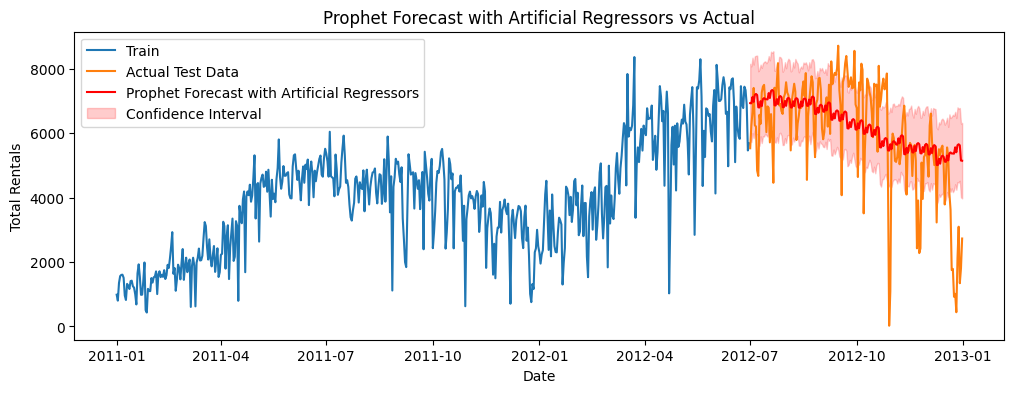

Prophet with Artificial Regressors MAE: 1069.93
Prophet with Artificial Regressors RMSE: 1494.05


In [ ]:
# Implement a Prophet model with artificial regressors.
# We will use the artificial avgTemp and antiRain data generated earlier as extra regressors
# to see how they influence the bike rental forecast.

# Import the Prophet model.
from prophet import Prophet

# Prepare the data for Prophet.
# Prophet requires the input DataFrame to have two columns: 'ds' (datetime) and 'y' (the value to forecast).
# We also need to include the extra regressors.
# Our original 'df' DataFrame has the date as the index and 'cnt' and weather columns.
# We need to reset the index and rename 'dteday' to 'ds' and 'cnt' to 'y'.
# We also need to ensure the weather columns are included.

# Create a DataFrame with the artificial weekly data and resample to daily, forward-filling
artificial_data_daily_interp = artificial_data[['avgTempFor', 'avgRainfall']].resample('D').ffill()

# We need to calculate the flipped rainfall (antiRain) for the daily data as well
mean_rainfall_daily = artificial_data_daily_interp['avgRainfall'].mean()
artificial_data_daily_interp['antiRain'] = mean_rainfall_daily - (artificial_data_daily_interp['avgRainfall'] - mean_rainfall_daily)

# Merge the daily bike rental data with the interpolated artificial data
df_prophet_artificial = df_daily.reset_index().rename(columns={'dteday': 'ds', 'cnt': 'y'})
df_prophet_artificial = df_prophet_artificial.merge(artificial_data_daily_interp[['avgTempFor', 'antiRain']], left_on='ds', right_index=True, how='left')

# Fill any resulting NaN values in the regressor columns using forward fill and then backward fill
# This handles NaNs at the beginning, end, or in the middle.
df_prophet_artificial[['avgTempFor', 'antiRain']] = df_prophet_artificial[['avgTempFor', 'antiRain']].fillna(method='ffill').fillna(method='bfill')


# Split the data for Prophet (using the same split as before).
train_prophet_artificial = df_prophet_artificial[df_prophet_artificial['ds'] <= '2012-06-30']
test_prophet_artificial = df_prophet_artificial[df_prophet_artificial['ds'] > '2012-06-30']

# Define and fit the Prophet model with artificial regressors.
model_prophet_artificial = Prophet()

# Add the artificial regressors to the model.
model_prophet_artificial.add_regressor('avgTempFor')
model_prophet_artificial.add_regressor('antiRain')

# Fit the model to the training data including the regressors.
model_prophet_artificial.fit(train_prophet_artificial)

# Make predictions on the future dates (test set dates) including the artificial regressors.
# We need the future values of the artificial regressors.
future_artificial = model_prophet_artificial.make_future_dataframe(periods=len(test_prophet_artificial), include_history=False)
# Merge with the artificial data to get the regressor values for the forecast period
future_artificial = future_artificial.merge(artificial_data_daily_interp[['avgTempFor', 'antiRain']], left_on='ds', right_index=True, how='left')

# Ensure future regressors also have no NaNs, although less likely if artificial_data_daily_interp is complete
future_artificial[['avgTempFor', 'antiRain']] = future_artificial[['avgTempFor', 'antiRain']].fillna(method='ffill').fillna(method='bfill')


# Generate the forecast for these future dates with artificial regressors.
forecast_artificial = model_prophet_artificial.predict(future_artificial)

# Merge the actual test data with the forecast for visualisation and evaluation.
prophet_forecast_artificial = test_prophet_artificial.merge(forecast_artificial[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Visualise the results.
plt.figure(figsize=(12, 4))
plt.plot(train_prophet_artificial['ds'], train_prophet_artificial['y'], label='Train')
plt.plot(test_prophet_artificial['ds'], test_prophet_artificial['y'], label='Actual Test Data')
plt.plot(prophet_forecast_artificial['ds'], prophet_forecast_artificial['yhat'], label='Prophet Forecast with Artificial Regressors', color='red')
plt.fill_between(prophet_forecast_artificial['ds'], prophet_forecast_artificial['yhat_lower'], prophet_forecast_artificial['yhat_upper'], color='red', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title('Prophet Forecast with Artificial Regressors vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.show()

# Evaluate the Prophet Forecast with Artificial Regressors using MAE and RMSE.
mae_prophet_artificial = mean_absolute_error(prophet_forecast_artificial['y'], prophet_forecast_artificial['yhat'])
rmse_prophet_artificial = np.sqrt(mean_squared_error(prophet_forecast_artificial['y'], prophet_forecast_artificial['yhat']))

print(f"Prophet with Artificial Regressors MAE: {mae_prophet_artificial:.2f}")
print(f"Prophet with Artificial Regressors RMSE: {rmse_prophet_artificial:.2f}")

Model Comparison:


,Model,MAE,RMSE,MAPE (%)
0,Naive Forecast,1414,1777,180.30
1,ARIMA Forecast,1315,1762,198.55
2,Prophet (No Weather),3358,4265,346.04
3,Prophet (Weather),1433,1963,196.41
4,Prophet (Artificial Regressors),1070,1494,169.34



Context for MAE and RMSE:
Average daily rentals in the test set: 6042.94
Standard deviation of daily rentals in the test set: 1745.88

What are 'good' MAE and RMSE values?
- MAE and RMSE values should be interpreted relative to the scale of the data (average daily rentals).
- A good model would typically have MAE and RMSE values significantly lower than the average and standard deviation of the target variable.
- Lower MAE and RMSE values indicate better forecast accuracy.

Context for MAPE:
- MAPE represents the average percentage error relative to the actual values.
- A lower MAPE indicates a more accurate forecast.
- MAPE can be sensitive to small actual values or zero values.


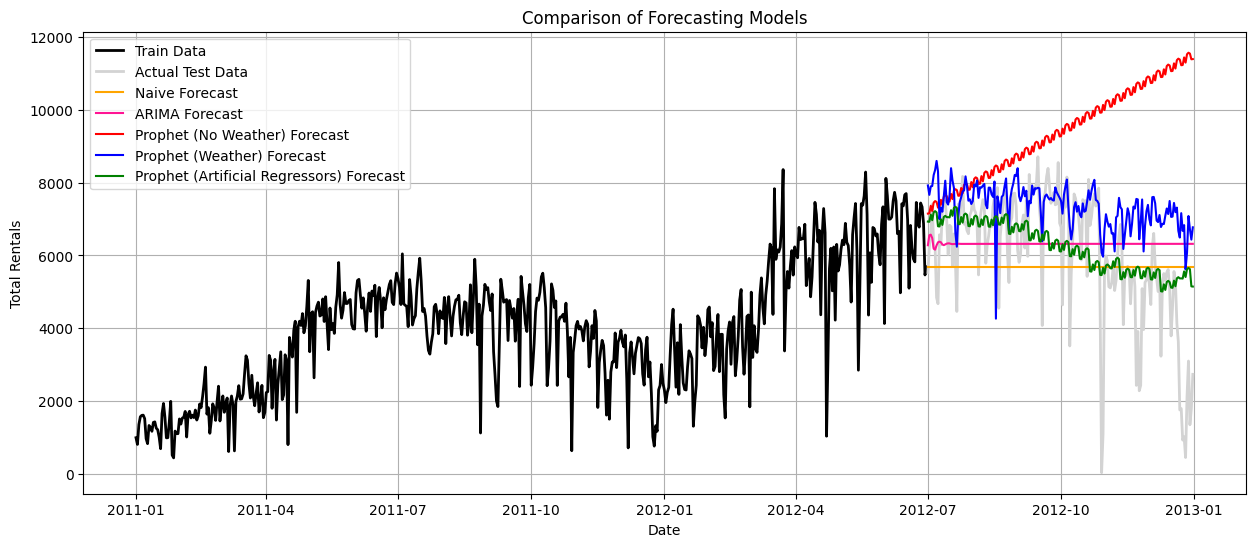

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero for actual values that are zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for each model
mape_naive = mean_absolute_percentage_error(test['cnt'], naive_forecast['naive'])
mape_arima = mean_absolute_percentage_error(test['cnt'], arima_forecast['arima_forecast'])
mape_prophet = mean_absolute_percentage_error(test['cnt'], prophet_forecast['yhat'])
mape_prophet_weather = mean_absolute_percentage_error(test['cnt'], prophet_forecast_weather['yhat'])
mape_prophet_artificial = mean_absolute_percentage_error(test['cnt'], prophet_forecast_artificial['yhat'])


# Define a dictionary to store the results
results = {
    'Model': ['Naive Forecast', 'ARIMA Forecast', 'Prophet (No Weather)', 'Prophet (Weather)', 'Prophet (Artificial Regressors)'],
    'MAE': [mae, mae_arima, mae_prophet, mae_prophet_weather, mae_prophet_artificial],
    'RMSE': [rmse, rmse_arima, rmse_prophet, rmse_prophet_weather, rmse_prophet_artificial],
    'MAPE (%)': [mape_naive, mape_arima, mape_prophet, mape_prophet_weather, mape_prophet_artificial]
}

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Round the metrics to the nearest whole number (except for MAPE, keep two decimal places)
results_df['MAE'] = results_df['MAE'].round(0).astype(int)
results_df['RMSE'] = results_df['RMSE'].round(0).astype(int)
results_df['MAPE (%)'] = results_df['MAPE (%)'].round(2) # Keep two decimal places for percentage


# Print the comparison table
print("Model Comparison:")
display(results_df)

# Provide context for MAE and RMSE values
# Calculate the mean and the actual daily rentals in the test set
mean_daily_rentals = test['cnt'].mean()
std_daily_rentals = test['cnt'].std()

print(f"\nContext for MAE and RMSE:")
print(f"Average daily rentals in the test set: {mean_daily_rentals:.2f}")
print(f"Standard deviation of daily rentals in the test set: {std_daily_rentals:.2f}")
print("\nWhat are 'good' MAE and RMSE values?")
print(f"- MAE and RMSE values should be interpreted relative to the scale of the data (average daily rentals).")
print(f"- A good model would typically have MAE and RMSE values significantly lower than the average and standard deviation of the target variable.")
print(f"- Lower MAE and RMSE values indicate better forecast accuracy.")
print(f"\nContext for MAPE:")
print(f"- MAPE represents the average percentage error relative to the actual values.")
print(f"- A lower MAPE indicates a more accurate forecast.")
print(f"- MAPE can be sensitive to small actual values or zero values.")


# Plot all forecasts against the training and actual test data
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train['cnt'], label='Train Data', color='black', linewidth=2)
# Plot actual test data
plt.plot(test['cnt'], label='Actual Test Data', color='lightgrey', linewidth=2)

# Plot each forecast with diverse colors and solid lines
plt.plot(naive_forecast.index, naive_forecast['naive'], label='Naive Forecast', color='orange', linestyle='-', linewidth=1.5)
plt.plot(arima_forecast.index, arima_forecast['arima_forecast'], label='ARIMA Forecast', color='deeppink', linestyle='-', linewidth=1.5) # Using 'deeppink' for hot pink
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet (No Weather) Forecast', color='red', linestyle='-', linewidth=1.5)
plt.plot(prophet_forecast_weather.index, prophet_forecast_weather['yhat'], label='Prophet (Weather) Forecast', color='blue', linestyle='-', linewidth=1.5)
plt.plot(prophet_forecast_artificial.index, prophet_forecast_artificial['yhat'], label='Prophet (Artificial Regressors) Forecast', color='green', linestyle='-', linewidth=1.5)


# Remove explicit x-axis limits to show the full data range
# plt.xlim(test.index.min(), test.index.max())

plt.title('Comparison of Forecasting Models')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.grid(True)
plt.show()

Prophet (No Weather) Forecast Data:
  Min Date: 2012-07-01 00:00:00
  Max Date: 2012-12-31 00:00:00
  Min Forecast Value (yhat): 7151.04
  Max Forecast Value (yhat): 11576.82
  Contains NaNs in yhat: False

Prophet (Weather) Forecast Data:
  Min Date: 2012-07-01 00:00:00
  Max Date: 2012-12-31 00:00:00
  Min Forecast Value (yhat): 4260.50
  Max Forecast Value (yhat): 8599.56
  Contains NaNs in yhat: False

Prophet (Artificial Regressors) Forecast Data:
  Min Date: 2012-07-01 00:00:00
  Max Date: 2012-12-31 00:00:00
  Min Forecast Value (yhat): 5007.80
  Max Forecast Value (yhat): 7339.02
  Contains NaNs in yhat: False


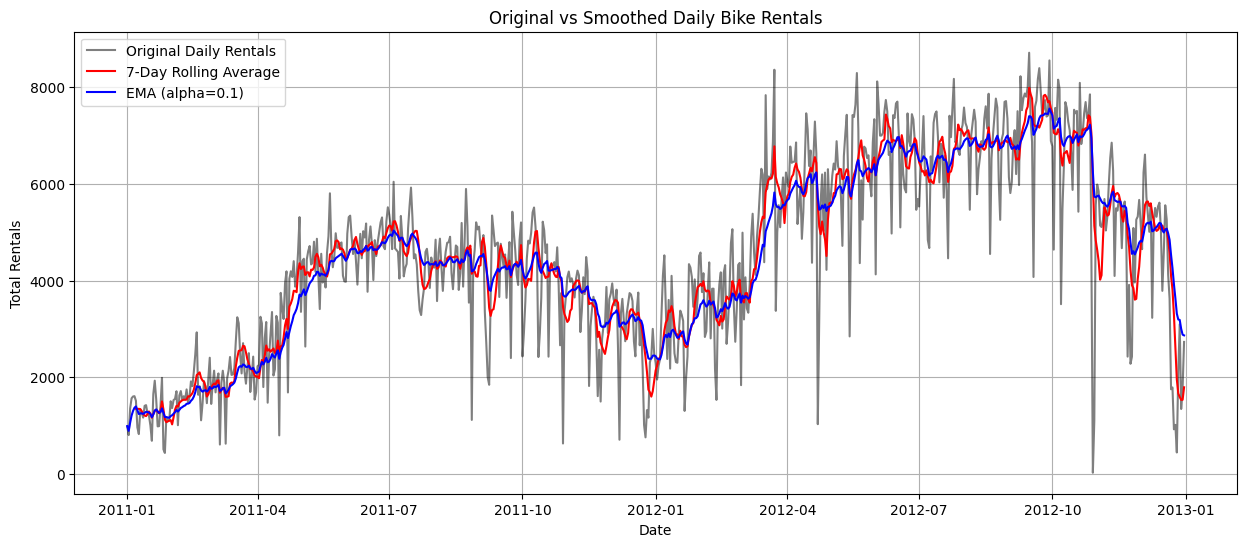

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine the training and testing data for smoothing
combined_data = pd.concat([train['cnt'], test['cnt']])

# Apply a smoothing technique (e.g., a rolling average)
# Choose a window size for the rolling average. A larger window results in more smoothing.
window_size = 7  # Example: 7-day rolling average
smoothed_data_rolling = combined_data.rolling(window=window_size).mean()

# Apply another smoothing technique (e.g., Exponential Moving Average - EMA)
# alpha is the smoothing factor, typically between 0 and 1.
# Smaller alpha values give more weight to past observations, resulting in smoother lines.
alpha_ema = 0.1 # Example: Smoothing factor
smoothed_data_ema = combined_data.ewm(alpha=alpha_ema).mean()


# Plot the original and smoothed data
plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(combined_data.index, combined_data.values, label='Original Daily Rentals', color='black', alpha=0.5)

# Plot Rolling Average smoothed data
plt.plot(smoothed_data_rolling.index, smoothed_data_rolling.values, label=f'{window_size}-Day Rolling Average', color='red')

# Plot EMA smoothed data
plt.plot(smoothed_data_ema.index, smoothed_data_ema.values, label=f'EMA (alpha={alpha_ema})', color='blue')


plt.title('Original vs Smoothed Daily Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.grid(True)
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/fpwsm5e3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r26o186/hyvh_mn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23037', 'data', 'file=/tmp/tmp3r26o186/fpwsm5e3.json', 'init=/tmp/tmp3r26o186/hyvh_mn6.json', 'output', 'file=/tmp/tmp3r26o186/prophet_modelgmcomb5h/prophet_model-20250628173927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model fitted.


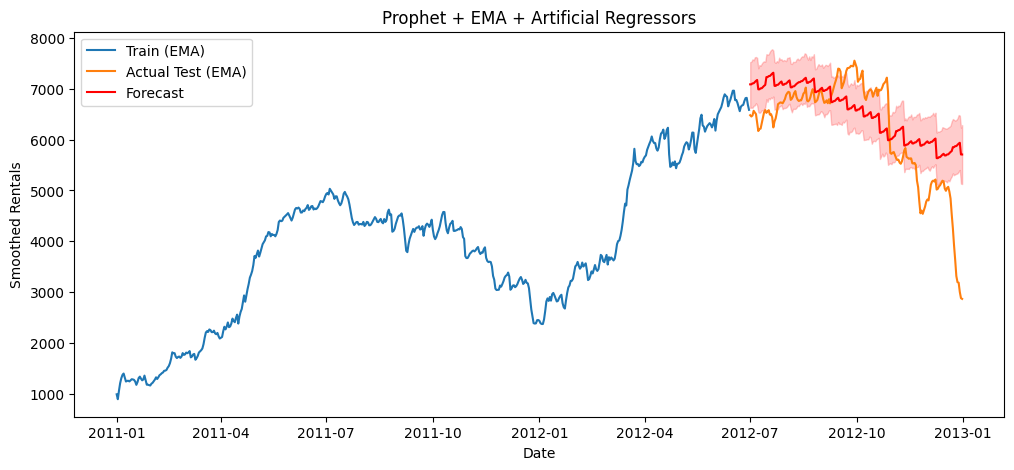

MAE:  635.06
RMSE: 819.78
MAPE: 12.28%


In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. MAPE metric
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# 2. Split EMA‐smoothed series into train/test
train_ema = smoothed_data_ema[:'2012-06-30']
test_ema  = smoothed_data_ema['2012-07-01':]

# 3. Build train/test DataFrames for Prophet
train_df = train_ema.rename_axis('ds').reset_index(name='y')
test_df  = test_ema.rename_axis('ds').reset_index(name='y')

# 4. Ensure your artificial regressor DataFrame has a 'ds' column:
art_df = artificial_data_daily_interp.copy()

# If it’s indexed by date and has no 'ds' column, reset it:
if 'ds' not in art_df.columns:
    art_df = (
        art_df
        .reset_index()        # index (the dates) → a column named 'index'
        .rename(columns={'index':'ds'})
    )

# 5. Merge in regressors
train_df = train_df.merge(art_df[['ds','avgTempFor','antiRain']], on='ds', how='left')
test_df  = test_df.merge( art_df[['ds','avgTempFor','antiRain']], on='ds', how='left')

# 6. Fill any gaps
for df in (train_df, test_df):
    df[['avgTempFor','antiRain']] = df[['avgTempFor','antiRain']].ffill().bfill()

# 7. Fit Prophet with regressors
m = Prophet()
m.add_regressor('avgTempFor')
m.add_regressor('antiRain')
m.fit(train_df)
print("Prophet model fitted.")

# 8. Build future frame for the test period
future = m.make_future_dataframe(periods=len(test_df), freq='D', include_history=False)
future = future.merge(art_df[['ds','avgTempFor','antiRain']], on='ds', how='left')
future[['avgTempFor','antiRain']] = future[['avgTempFor','antiRain']].ffill().bfill()

# 9. Predict
forecast = m.predict(future)

# 10. Plot results
plt.figure(figsize=(12,5))
plt.plot(train_df['ds'], train_df['y'],                label='Train (EMA)')
plt.plot(test_df['ds'],  test_df['y'],                 label='Actual Test (EMA)')
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Forecast')
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='red', alpha=0.2)
plt.legend()
plt.title('Prophet + EMA + Artificial Regressors')
plt.xlabel('Date')
plt.ylabel('Smoothed Rentals')
plt.show()

# 11. Evaluate
fcst_test = forecast.set_index('ds').loc[test_df['ds'], 'yhat']
y_test    = test_df.set_index('ds')['y']

mae  = mean_absolute_error(y_test, fcst_test)
rmse = np.sqrt(mean_squared_error(y_test, fcst_test))
mape = mean_absolute_percentage_error(y_test, fcst_test)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


# Summary

**The Prophet model achieves an MAE of 635, RMSE of 820, and MAPE of 12.3%, placing it in the “Good” accuracy range (10–20% MAPE). Further improvements towards the “Excellent” band (<10% MAPE) may be attained through incorporation of supplementary regressors (holidays, events, weather extremes), hyperparameter optimisation (e.g. `changepoint_prior_scale`), and validation via cross-validation.**
